In [1]:
import torch
import torchvision
from torchvision.transforms import v2

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

import collections 

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


class Conv(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 128, 3) 
        self.bn1 = torch.nn.BatchNorm2d(128)    
        self.relu1 = torch.nn.ReLU()
        self.drop1 = torch.nn.Dropout2d(0.3)

        self.conv2 = torch.nn.Conv2d(128, 256, 3)
        self.bn2 = torch.nn.BatchNorm2d(256)
        self.relu2 = torch.nn.ReLU()
        self.drop2 = torch.nn.Dropout2d(0.3)

        self.maxpool1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(256, 512, 3)
        self.bn3 = torch.nn.BatchNorm2d(512)        
        self.relu3 = torch.nn.ReLU()
        self.drop3 = torch.nn.Dropout2d(0.3)

        self.conv4 = torch.nn.Conv2d(512, 512, 3)
        self.bn4 = torch.nn.BatchNorm2d(512)
        self.relu4 = torch.nn.ReLU()
        self.drop4 = torch.nn.Dropout2d(0.3)

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(12800, num_classes) 

    def forward(self, x):
        # input = (batch_size, 3, 32, 32)
        x = self.conv1(x)                  # output = (batch_size, 128, 30, 30) 
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)

        x = self.conv2(x)                  # output = (batch_size, 256, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop2(x)

        x = self.maxpool1(x)               # output = (batch_size, 256, 14, 14)

        x = self.conv3(x)                  # output = (batch_size, 512, 12, 12)                     
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.drop3(x)

        x = self.conv4(x)                  # output = (batch_size, 512, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.drop4(x)

        x = self.maxpool2(x)               # output = (batch_size, 512, 5, 5)     512 x 5 x 5 = 12800

        x = torch.flatten(x, 1)             
        x = self.fc1(x)                                                                                     

        return x 

In [4]:
pathTest = '../test_images'

# Batch size - It can influence speed and generalization, not necessarily in the same direction. 
# There is no golden rule for the batch size but 32 is a commom number to start with.
BATCH_SIZE = 32

IMAGE_SIZE = 32
EPOCHS = 40

NUM_MODELS = 5

In [5]:
transform_test = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomAutocontrast(p=1.0),          # Apply autocontrast to the image
    v2.ToImage(),                          # Convert to tensor
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

# No shuffle is required for the test set, also the batch size can be completely different
test_set = torchvision.datasets.ImageFolder(root=pathTest, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [6]:
model = Conv(len(test_set.classes))
model.to(device)

Conv(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout2d(p=0.3, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (drop3): Dropout2d(p=0.3, inplace=False)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (drop4): Dropout2d(p=0.3, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, pa

In [7]:
models = []
acc = []

# Load the five best models
for i in range(NUM_MODELS):
    reload = torch.load(f'best_model_{i}.pt')
    model = Conv(len(test_set.classes))                                           
    model.load_state_dict(reload['model'])
    model.to(device)
    models.append(model)
    acc.append(evaluate(models[i], test_loader))

0.9936975479125977 0.9972288012504578 0.9831354022026062


(0.99, 1.0)

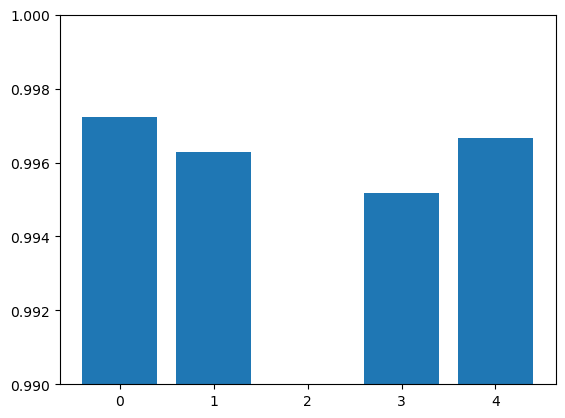

In [8]:
index = [i for i in range(NUM_MODELS)]
  
plt.bar(index, acc)
print(np.mean(acc), np.max(acc), np.min(acc))
plt.ylim(0.99,1.0)

In [9]:
def get_labels_logits_and_preds(models):

    with torch.no_grad():
        logits = [[] for _ in range(NUM_MODELS)]
        labels = []

        for images, labs in test_loader:

            images = images.to(device)
            labels.extend(labs)
            
            for i in range(NUM_MODELS):
                logits[i].extend(models[i](images).cpu())
    return labels, logits

labels, logits = get_labels_logits_and_preds(models)

In [10]:
preds = [[] for _ in range(len(labels)) ]

for index in range(len(labels)):
    preds[index] = [np.argmax(logits[m][index].cpu().numpy()) for m in range(NUM_MODELS)]

print(preds[4000]) # 4000 is the index of the image

[8, 8, 8, 8, 8]


In [11]:
def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(len(logits[0])):

        log = logits[0][i]
        for m in range(1, NUM_MODELS):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)
    
class_logits = get_class_from_sum_of_logits(logits)
print(class_logits[0])

tensor(0)


In [12]:
def VotingEnsemble(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0

    for k in range(len(labels)):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1

        count += 1 
        
    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong]
    
    
res = VotingEnsemble(labels, preds, class_logits)
print('total: ', res[0])
print('All correct: ', res[1])
print('All incorrect: ', res[2])
print('Majority correct: ', res[3])
print('Tie Vote: ', res[4])
print('Majority Wrong: ', res[5])
print('Percentage right: ', (res[1]+res[3])/res[0])

total:  12630
All correct:  12345
All incorrect:  3
Majority correct:  252
Tie Vote:  11
Majority Wrong:  19
Percentage right:  0.9973871733966746
